# Training Notebook

In [1]:
import numpy as np

In [2]:
from Bio import SeqIO

positives = []
negatives = []

with open("positives.fasta", "r") as input_handle:
    for record in SeqIO.parse(input_handle, "fasta"):
        positives.append(str(record.seq))
with open("negatives.fasta", "r") as input_handle:
    for record in SeqIO.parse(input_handle, "fasta"):
        negatives.append(str(record.seq))

In [3]:
positives

['MHTPIISETVQPKTAGLIVLGKASAETRGLSQGVEPDIGQTYFEESRINQD',
 'MNKQQQESGLLLAEESLMELCASSETLGGAGQYKEVEAGRWSDRIDSDDE',
 'MVRLLAKLLRSTIHGSNGVSLDAVSSTHGTPGFQTPDARVISRFGFN',
 'MERIEDHIDDELIDLGAASVETQGDVLNAPEPGIGREPTGLSRD',
 'MQRIIDETTDGLIELGAASVQTQGDVLFAPEPGVGRPPMGLSED',
 'MTKKNATQAPRLVRVGDAHRLTQGAFVGQPEAVNPLGREIQG',
 'MTKTHRLIRLGDAQRLTQGTLTPGLPEDFLPGHYMPG',
 'MTSRFQLLRLGKADRLTRGALVGLLLEDITVARYDPM',
 'MTSQPSKKTYNAPSLVQRGKFARTTAGSQLVYREWVGHSNVIKPGP',
 'MDEELELEIVDLGDAKELTQGAPSLINSEDNPAFPQRV',
 'MDRHDNSEVDEIIDLGTASAVTQGMGSGSTDQNGQPKNLIGGISDD',
 'MKQQKQQKKAYVKPSMFQQGDFSKKTAGYFVGSYKEYWSRRII',
 'MLISTTNGQGTPMTSTDELYEAPELIEIGDYAELTRCVWGGDCTDFLGCGTAWICV',
 'MIKHFHFNKLSSGKKNNVPSPAKGVIQIKKSASQLTKGGAGHVPEYFVGIGTPISFYG']

In [4]:
import re
def vectorize(sequence_list):
    vector_arr = []
    aa_rep = np.matrix([[ 0.20412415,  0.15567426,  0.03942035, -0.01822488, -0.14819245,
          0.19802112, -0.43177231,  0.3272457 , -0.18397928,  0.37255573,
         -0.10809339,  0.2117906 , -0.06704938,  0.00071176, -0.22053608,
          0.35334939, -0.0543725 ,  0.17522578, -0.06132986,  0.22112548,
         -0.18809861, -0.03007737,  0.21668077,  0.02817936],
        [ 0.20412415, -0.16717617,  0.04522636,  0.0527608 , -0.06514745,
          0.10555747,  0.3294438 ,  0.15377643, -0.14839629,  0.05564137,
          0.44142262,  0.26383881, -0.27165656, -0.21415267, -0.03675024,
         -0.13039611,  0.30409053,  0.06596975, -0.37842362,  0.18876561,
          0.22838388, -0.06952343, -0.03159155, -0.12939871],
        [ 0.20412415,  0.1718496 ,  0.21887519,  0.1676149 ,  0.0961377 ,
          0.15366935, -0.12880583,  0.16764423, -0.43199321, -0.04598926,
         -0.06827292, -0.35602773,  0.14094867,  0.10767668,  0.18162269,
         -0.3756231 ,  0.24412855,  0.09623603, -0.10614588, -0.22846791,
         -0.2298419 ,  0.02849644, -0.03571025, -0.24963588]])
    btranslator = np.matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])
    def get_cores(sequence_list):
        leaders = []
        cores = []
        tails = []
        for seq in sequence_list:
            last_ind = 0
            while((last_ind < len(seq) - 1) and last_ind != -1):
                try:
                    new_term = seq.index('T', last_ind + 1)
                    if(new_term > 15 and new_term <= 46):
                        leader = seq[0:new_term + 2]  
                        remainder = seq[new_term + 2:]
                        core = re.findall("[A-Z]{6,8}[DE]", remainder)[0]
                        remainder = remainder[len(core):]
                        #M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
                        leaders.append(leader)
                        cores.append(core)
                        tails.append(remainder)
                    last_ind = new_term
                except: 
                    break
        return {
          "leaders": leaders,
          "cores": cores,
          "tails": tails
         }
    def vectorize_swanson(sequence_list):
        maxLen = 9
        arr = np.zeros((26 * maxLen, len(sequence_list)))
        for i in range(0, len(sequence_list)):
            rowIndex = 0
            for char in sequence_list[i]:
                arr[rowIndex + (ord(char) - 65), i] = 1
                rowIndex += 26
            mod_arr = np.zeros((3 * maxLen, len(sequence_list)))
            rowIndex = 0
            for i in range(0, np.shape(arr)[0], 26):
                new_three = np.matmul(aa_rep, np.matmul(btranslator, arr[i:(i+26), :]))
                mod_arr[rowIndex:(rowIndex + 3), :] = new_three
                rowIndex += 3
        return mod_arr
    
    s_list = get_cores(sequence_list)["cores"]
    
    return vectorize_swanson(s_list)


In [5]:
pos_matrix = np.transpose(np.matrix(vectorize(positives)))
neg_matrix = np.transpose(np.matrix(vectorize(negatives)))

## Principal Component Analysis
Quick visualization to see the vector space in three principal components

In [6]:
normal_neg = neg_matrix - np.mean(neg_matrix,0)
normal_pos = pos_matrix - np.mean(pos_matrix,0)

In [7]:
S = np.transpose(normal_neg) @ normal_neg
S = S / len(normal_neg)
print(S.shape)
val, vec = np.linalg.eigh(S)
b1 = vec[0]
# b1 = b1.reshape(b1.shape[0], 1)
b2 = vec[1]
# b2 = b2.reshape(b2.shape[0], 1)
b3 = vec[2]
# b3 = b3.reshape(b3.shape[0], 1)

(27, 27)


In [8]:
x_n = b1 @ np.transpose(normal_neg)
y_n = b2 @ np.transpose(normal_neg)
z_n = b3 @ np.transpose(normal_neg)
x_p = b1 @ np.transpose(normal_pos)
y_p = b2 @ np.transpose(normal_pos)
z_p = b3 @ np.transpose(normal_pos)

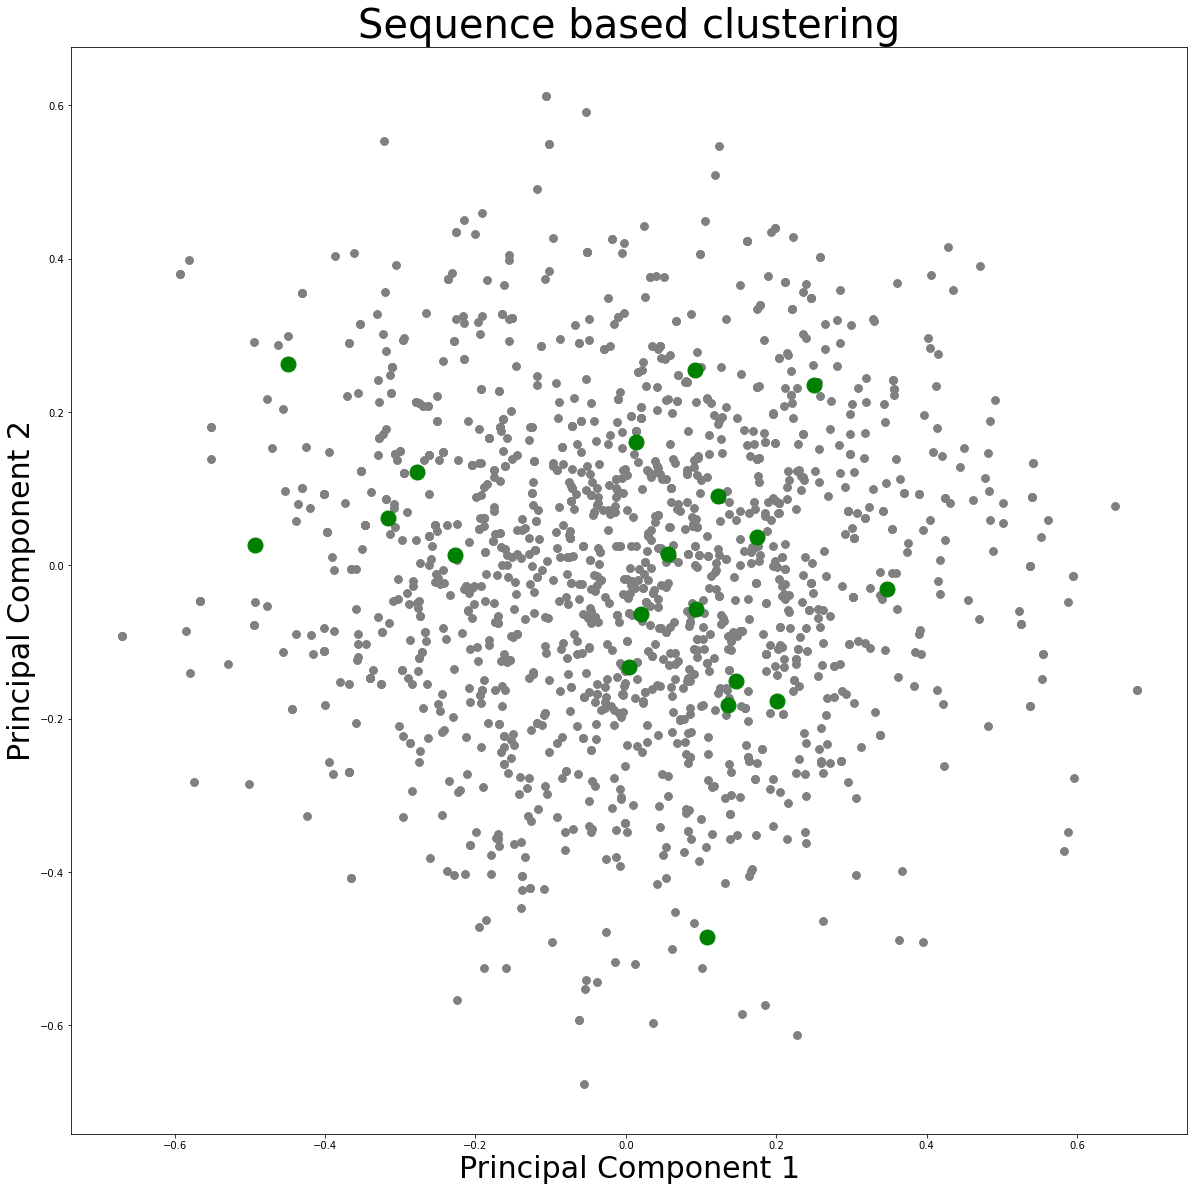

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20));
plt.xlabel("Principal Component 1", fontsize=30);
plt.ylabel("Principal Component 2", fontsize=30);
plt.title("Sequence based clustering", fontsize=40);
plt.plot(x_n, y_n, '.', color="gray", markersize=15);
plt.plot(x_p, y_p, '.', color="green", markersize=30);

## SVM Training

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
pos_train, pos_test = train_test_split(pos_matrix, test_size=0.33, random_state=42)
neg_train, neg_test = train_test_split(neg_matrix, test_size=0.33, random_state=12)

In [12]:
training_matrix = np.concatenate((pos_train, neg_train[0:1280]))
testing_matrix = np.concatenate((pos_test, neg_test))

In [13]:
training_labels = np.zeros((training_matrix.shape[0],))
training_labels[:pos_train.shape[0]] += 1

In [14]:
testing_labels = np.zeros((testing_matrix.shape[0],), dtype=int)
testing_labels[:pos_test.shape[0]] += 1

In [15]:
# from sklearn import svm
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=6000)
# clf = svm.SVC(kernel="sigmoid", probability=True)

In [16]:
clf.fit(training_matrix, training_labels)

MLPClassifier(max_iter=6000, random_state=1)

In [17]:
predictions = clf.predict(testing_matrix)

In [18]:
false_positives = 0
false_negatives = 0
true_positives = 0
true_negatives = 0
for ind in range(0, len(predictions)):
    if(testing_labels[ind] == 1):
        if(predictions[ind] == 1):
            true_positives += 1
        else:
            false_negatives += 1
    else:
        if(predictions[ind] == 1):
            false_positives += 1
        else:
            true_negatives += 1

In [19]:
print(f'True Positives: {true_positives}')
print(f'False Positives: {false_positives}')
print(f'True Negatives: {true_negatives}')
print(f'False Negatives: {false_negatives}')
print('----------------------------------')
print(f'Sensitivity: {true_positives / (true_positives + false_negatives)}')
print(f'Specificity: {true_negatives / (true_negatives + false_positives)}')

True Positives: 0
False Positives: 0
True Negatives: 1043
False Negatives: 7
----------------------------------
Sensitivity: 0.0
Specificity: 1.0


In [20]:
predictions = clf.predict_proba(testing_matrix)

In [21]:
predictions[0:15]

array([[9.88005554e-01, 1.19944460e-02],
       [7.60588247e-01, 2.39411753e-01],
       [9.97505551e-01, 2.49444901e-03],
       [9.99779720e-01, 2.20280402e-04],
       [9.99981570e-01, 1.84298855e-05],
       [9.79745015e-01, 2.02549852e-02],
       [8.98852921e-01, 1.01147079e-01],
       [9.99990742e-01, 9.25844485e-06],
       [9.93281974e-01, 6.71802629e-03],
       [9.99975703e-01, 2.42972930e-05],
       [9.99735799e-01, 2.64200886e-04],
       [9.94291516e-01, 5.70848412e-03],
       [9.98009443e-01, 1.99055720e-03],
       [9.99374716e-01, 6.25283736e-04],
       [9.99910588e-01, 8.94117654e-05]])

In [22]:
def lasso_classifier(sequence_list):
    scores = []
    for seq in sequence_list:
        vector_matrix = np.matrix(vectorize([seq]))
        max_score = 0
        for i in range(0, vector_matrix.shape[1]):
            temp_score = np.matrix(clf.predict_proba(np.transpose(vector_matrix[:,i])))[:,1]
            if(temp_score > max_score):
                max_score = temp_score
        scores.append(np.sum(max_score))
        # scores.append(np.maximum(np.matrix(clf.predict_proba(vectorize([seq])))[:,1]))
    return(scores)

In [23]:
positive_scores = lasso_classifier(positives)
negative_scores = lasso_classifier(negatives)

In [24]:
print(f'Average positive score: {np.sum(positive_scores) / len(positives)}')
print(f'Average negative score: {np.sum(negative_scores) / len(negatives)}')
print(f'Ratio: {(np.sum(positive_scores) / len(positives)) / (np.sum(negative_scores) / len(negatives))}')

Average positive score: 0.4798930978511944
Average negative score: 0.0057187388404394066
Ratio: 83.91589671094705


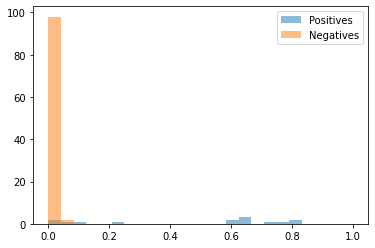

In [25]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0, 1, 25)

pyplot.hist(positive_scores, bins, alpha=0.5, label='Positives')
pyplot.hist(negative_scores[0:100], bins, alpha=0.5, label='Negatives')
pyplot.legend(loc='upper right')
pyplot.show()

In [26]:
len(positive_scores)

14

In [27]:
fpr = []
tpr = []
true_positives = len(positive_scores)
true_negatives = len(negative_scores)
for cutoff in np.linspace(0,1,50):
    tpr.append(np.sum(positive_scores >= cutoff) / true_positives)
    fpr.append(1 - (np.sum(negative_scores < cutoff) / true_negatives))

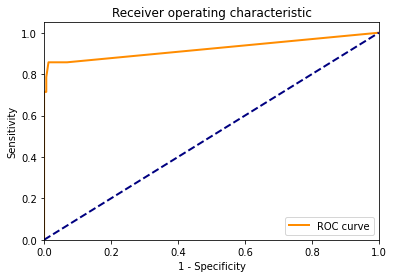

In [28]:
pyplot.figure()
lw = 2
pyplot.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
pyplot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('1 - Specificity')
pyplot.ylabel('Sensitivity')
pyplot.title('Receiver operating characteristic')
pyplot.legend(loc="lower right")
pyplot.show()

# Export Models

In [30]:
import dill as pickle

with open('NN.pickle', 'wb') as f:
    pickle.dump(clf, f)
with open('vectorize.pickle', 'wb') as f:
    pickle.dump(vectorize, f)

# Run Classifier
Load and test the classifier function

In [5]:
import dill as pickle
import numpy as np
from numpy import log2

with open('SVMsigmoid.pickle', 'rb') as g:
    clf = pickle.load(g)
with open('vectorize.pickle', 'rb') as g:
    vectorize = pickle.load(g)

In [6]:
def classify(sequence_list):
    return(np.matrix(clf.predict_proba(vectorize(sequence_list)))[:,1])

In [7]:
classify(["MYPLAIGHEPGVIGTGAEDFTVLIGGGFELNLEGGLRCRTDQG"])

matrix([[0.19417684]])